<a href="https://colab.research.google.com/github/Javier9898/Sports_Recognition_With_Deep_Learning/blob/master/Sport's_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sports Recognition**



## **Introduction**

Its amazing how powerful neural network applications in a variety of fields, like image classification, segmentation, time series forecast and many others, can be. Sometimes we forget how far we've come, from the computers we used as calculating devices all the way to the ones that drive our cars and learn by themselves. For this project I've built a sports classifier to identify different sports using deep learning techniques. 

## **Objectives**
In this project, deep learning will be utilized to determine the name of a sport that is shown based purely on an image of that sport. To accomplish this, I will use a variety of images from different sports to train a capable model.

## **Data files:**
All data was collected using Google Images and a Google Chrome extension called "Fatkun Batch" which allowed me to download the amount of google images needed.

## **Sources**

Based on: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb


---


## **Code**

### **Libraries**

In [1]:
#making sure fastai is up to date 
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
import numpy as np #  multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
import pandas as pd # data manipulation

# data visualization libraries
import matplotlib.pyplot as plt  
import seaborn as sns 
import plotly.graph_objs as go
from plotly.offline import iplot

from  google.colab import drive #Used to access personal Google Drive

from fastai.vision import * #Used to build models

print("Done")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Done


### **Enterining My Google Drive To Gain Access To My Data**

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Saving path to project folder for convenience
root_path = 'gdrive/My Drive/Recognition_Project/'

In [5]:
# This creates a folder called 'Sports' in my Googe Drive
# Its commented so it doesn't override my existing 'Sports' folder
#(Path(root_path)/'Sports').mkdir(parents=True, exist_ok=True)

In [6]:
# Saving path to project folder for convenience
proj_path = 'gdrive/My Drive/Recognition_Project/Sports/'

In [7]:
# Saving the path for fastai use
p_path = Path(proj_path)

### **Data Pre-Processing**

In [8]:
# Creating image data bunch with 80/20 train test split 
# Applying some transformations, resizing to 224 x 224(for deep learning a square picture makes the most sense)
np.random.seed(42)
data = ImageDataBunch.from_folder(p_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['american football',
  'baseball',
  'basketball',
  'ice hockey',
  'soccer',
  'tennis'],
 6,
 517,
 129)

There are 6 classes, 517 of the images will be used for training, the remaining 129 are reserved for testing

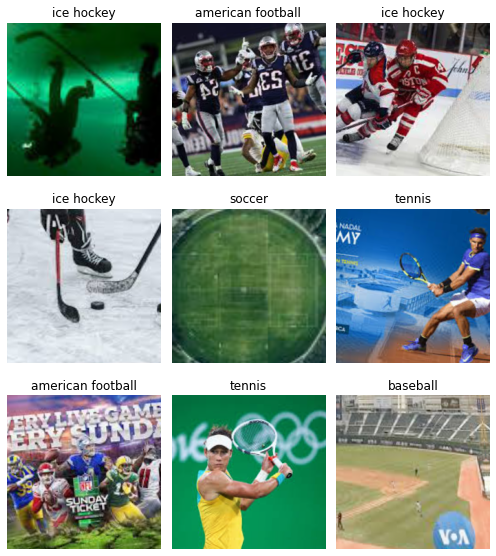

In [10]:
#show sample of images 
data.show_batch(rows=3,figsize=(7,8))

### **Training The Model**

I'm going to run the data gathered through a pre-existing model called "resnet34" which is a really good image classifier neural net. As metrics i've decided to use "error rate" which is 1 minus the accuracy (the closer the error rate is to 0, the more accurate it is).

In [11]:
# creating cnn_learner object
# using resnet 34 for transfer learning 
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [12]:
# training 8 epochs of the model 
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.935660,1.378468,0.457364,00:53
1,1.951152,0.558010,0.170543,00:07
2,1.392889,0.513174,0.131783,00:07
3,1.057244,0.528953,0.108527,00:07
4,0.849952,0.526803,0.116279,00:07
5,0.697133,0.529909,0.131783,00:07
6,0.588221,0.538118,0.131783,00:07
7,0.502326,0.535246,0.131783,00:07


The model is about 90% accurate

In [13]:
#saving model
learn.save('model1_01', return_path=True)

PosixPath('gdrive/My Drive/Recognition_Project/Sports/models/model1_01.pth')

### **Retraining The Model In Hopes Of A Better Accuracy Score**

In [14]:
# unfreezing model to train earlier layers 
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


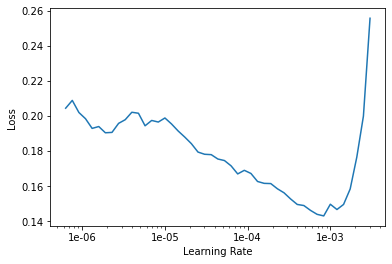

In [15]:
# Finding the optimal learning rates 
# Applying these parameters to the models might imporve it
learn.lr_find()
learn.recorder.plot()

Generally its best to choose a learning rate thats pretty steep. In this case from 1e-6 to 1e-4 looks good.

In [16]:
# fitting whole model with new learning rates 
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4), wd=.001)

epoch,train_loss,valid_loss,error_rate,time
0,0.203793,0.523785,0.131783,00:07
1,0.208978,0.529785,0.131783,00:07


The model doesn't end up getting any better...

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


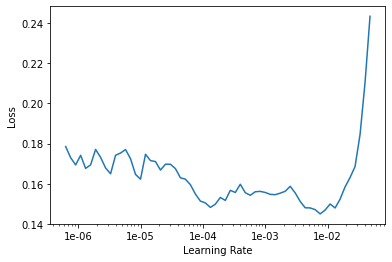

In [17]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

The lines did get more steep from the previous one which is good.

### **Exploring The Model**

In [18]:
# Loading the first model since both models are mostly identical
learn.load('model1_01')
interp = ClassificationInterpretation.from_learner(learn)

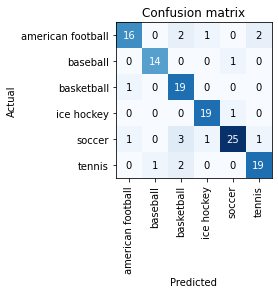

In [19]:
#plot results of model on validation set 
interp.plot_confusion_matrix()

It seems like the model had the most confussion identifying basketball and tennis apart.

Let's look at the images the model had a difficult time identifying

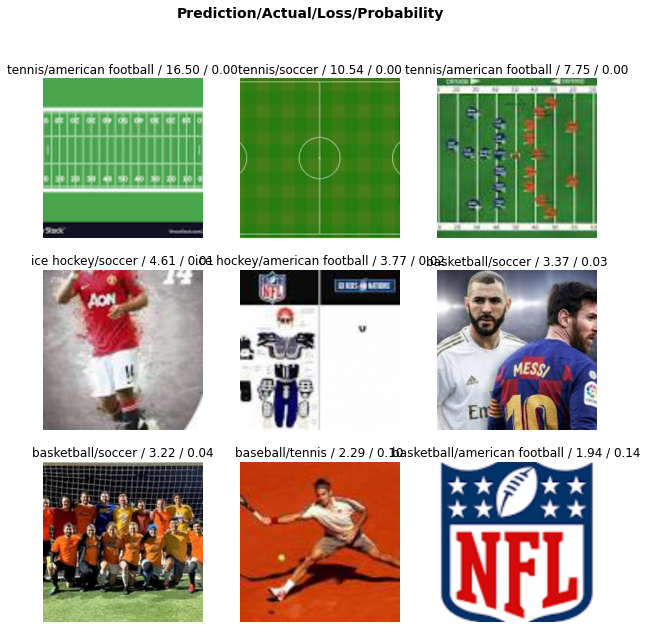

In [20]:
# plot top losses (most wrong)
interp.plot_top_losses(9, figsize=(10,10))

Some of these images could be considered hard to identify by a human aswell. Maybe if there were more data these misses wouldn't happen.

### **Testing The Model**

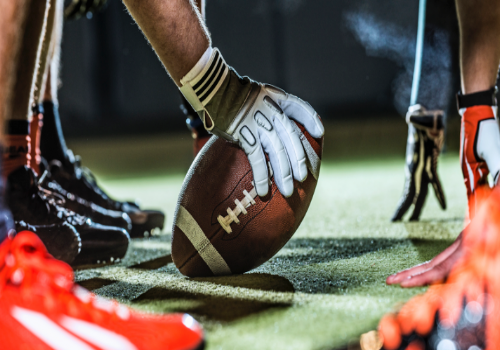

In [21]:
img_football= open_image(Path(root_path)/'Test_img'/'football (1).png')
img_football.resize((200, 350, 500))

In [22]:
pred_class,pred_idx,outputs = learn.predict(img_football)
print(pred_class)

american football


As seen, the model did well in predicting the sport the image is associated with.

## **Conclusion**

This model can be used to create an application where someone who is new to a sport could take a picture of a match and the app could serve them some information about the history and rules of the game. It'd also be interesting to collet that data and see which sports are the most unknown.